### Talib 지표 알고리즘으로 학습 시켜 성능 확인해보기
   - csv 파일로 저장된 df 를 불러와서 작업(csv 파일은 앞의 df 생성 코드로부터 생성) 
   - 알고리즘은 회귀를 써본 후 LSTM 을 적용하여 시계열 데이터에 적합 알고리즘을 비교 파악해보기

In [1]:
import numpy as np
import pandas as pd

In [2]:
samsung_df = pd.read_csv('./data/samsung_df_201028.csv', index_col=0)

In [3]:
# NaN 값이 없는 구간의 df만 추출
df = samsung_df.loc['2010-03-01':'2020-09-17', :]

In [4]:
df.head(3)

,open,high,low,close,volume,change,1month_close,1month_change,TARGET,_qcut,bol_upperband,bol_middleband,bol_lowerband,macd,macd_signal,macd_hist,bolinger_pca
Date,,,,,,,,,,,,,,,,,
2010-03-02,15220,15479,15120,15400,471552,0.034946,17380.0,0.128571,3.0,5.0,15738.107634,15241.0,14743.892366,-289.292188,-325.639030,36.346842,-30017.837579
2010-03-03,15420,15460,15260,15420,194602,0.001299,17180.0,0.114137,3.0,5.0,15720.283422,15235.0,14749.716578,-252.510304,-311.013285,58.502981,-30029.008039
2010-03-04,15420,15440,15120,15220,204388,-0.012970,17260.0,0.134034,3.0,5.0,15700.084026,15224.0,14747.915974,-236.769394,-296.164507,59.395112,-30048.653775


In [5]:
# 데이터와 답 분리

# 학습시킬 features 은 종가, 거래량, macd, bolinger 지표만으로 학습시켜 보겠다.
X_features = df[['close', 'volume','macd','macd_hist','bolinger_pca']]

# 답은 2개로 나누어서 각각 해볼것 : 1: 한달후 change인 1month_change 칼럼, 2: 1번을 카테고라이즈한 TARGET 칼럼
y_target_1 = df['1month_change']
y_target_2 = df['TARGET']

In [6]:
# 답의 분포 확인 : 수익율 자체를 답으로.
y_target_1.value_counts()

 0.000000    11
-0.027322     3
-0.080000     3
 0.019417     3
 0.006211     3
             ..
-0.100389     1
 0.107843     1
 0.012797     1
 0.084135     1
 0.111111     1
Name: 1month_change, Length: 2551, dtype: int64

In [7]:
# 답의 분포 확인 : 수익율 구간마다 점수를 매기고, 해당 점수를 답으로.
y_target_2.value_counts()

 1.0     755
-3.0     698
-5.0     360
 3.0     327
 0.0     279
-10.0    163
 5.0      24
Name: TARGET, dtype: int64

- 불균형한 데이터 셋은 아니다. 

### 1.   회귀(기본 선형 or 릿지or 라쏘)로 모델 생성

- 모델 생성의 이해를 위한 기본 모델 생성

- 시계열을 반영하지 않으므로, 매우 한정적인 정보로만 생성된 모델일 것.
- 예상 : 신뢰 수준은 낮을것임

#### 정규화하지 않고 해보기

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [9]:
# 학습, 테스트 데이터 분리
## 섞이므로 시계열은 아예 무시됨.
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target_2, test_size=0.3, random_state = 0)

In [10]:
# 선형회귀 모델로 학습/예측/평가
# mse, rmse는 작을수록, r2는 1에 가까울수록 예측성능이 좋은 것임
lr = LinearRegression()
lr.fit(X_train, y_train)
pred = lr.predict(X_test)
mse = mean_squared_error(y_test, pred)
rmse = np.sqrt(mse)
r2_ = r2_score(y_test, pred)

print('MSE : {0:.3f}, RMSE : {1:.3f}, R2 score : {2: .3f}'.format(mse, rmse, r2_))

MSE : 10.931, RMSE : 3.306, R2 score : -0.010


- 예상대로 MSE, RMSE 너무 높고, R2 score 너무 낮다

In [11]:
target_ = pd.DataFrame(y_test, columns=['TARGET'])


In [12]:
target_['pred'] = pred

In [13]:
target_[:10]

,TARGET,pred
Date,,
2019-07-19,-5.0,-2.004029
2019-12-13,3.0,-2.666616
2010-12-03,0.0,-1.433782
2019-11-01,-3.0,-2.370929
2013-10-31,-3.0,-1.312262
2014-08-04,-5.0,-1.216740
2019-03-11,1.0,-1.878838
2020-09-07,1.0,-2.396494
2015-07-02,-10.0,-1.348985


In [14]:
# 학습, 테스트 데이터 분리2
## train_test split 사용하지 않고 순서대로 임의로 자르기
### 데이터는 섞이지 않음
X_train = X_features[:2000]
X_test = X_features[2000:]
y_train = y_target_2[:2000]
y_test = y_target_2[2000:]

In [15]:
# 선형회귀 모델로 학습/예측/평가
# mse, rmse는 작을수록, r2는 1에 가까울수록 예측성능이 좋은 것임
lr = LinearRegression()
lr.fit(X_train, y_train)
pred = lr.predict(X_test)
mse = mean_squared_error(y_test, pred)
rmse = np.sqrt(mse)
r2_ = r2_score(y_test, pred)

print('MSE : {0:.3f}, RMSE : {1:.3f}, R2 score : {2: .3f}'.format(mse, rmse, r2_))

MSE : 983.440, RMSE : 31.360, R2 score : -76.017


- 이상한 값이 나옴. 식이 잘못된듯

In [16]:
target_ = pd.DataFrame(y_test, columns=['TARGET'])
target_['pred'] = pred

In [17]:
X_test

,close,volume,macd,macd_hist,bolinger_pca
Date,,,,,
2018-04-04,46920,247684,-174.365007,-422.100200,30270.039670
2018-04-05,48740,264912,-181.786607,-343.617439,30232.602374
2018-04-06,48400,250654,-212.652115,-299.586358,30122.441807
2018-04-09,49200,199008,-170.593443,-206.022149,30076.845795
2018-04-10,48880,219687,-161.224473,-157.322543,29830.231395
...,...,...,...,...,...
2020-09-11,59000,16017098,548.112537,359.702716,41698.649517
2020-09-14,60400,20648281,754.698531,453.030968,41930.720161
2020-09-15,61000,17877075,955.816349,523.319029,42182.873058


In [18]:
X_train

,close,volume,macd,macd_hist,bolinger_pca
Date,,,,,
2010-03-02,15400,471552,-289.292188,36.346842,-30017.837579
2010-03-03,15420,194602,-252.510304,58.502981,-30029.008039
2010-03-04,15220,204388,-236.769394,59.395112,-30048.653775
2010-03-05,15500,235291,-199.402364,77.409714,-30052.449112
2010-03-08,15720,391403,-150.303951,101.206502,-30032.992849
...,...,...,...,...,...
2018-03-28,48700,303189,467.900923,-150.617083,29664.289474
2018-03-29,49040,201340,352.475708,-212.833838,29824.243758
2018-03-30,49220,155542,272.385005,-234.339633,30074.358346


- close 값은 빼고 돌리는 것이 좋겠다. 

In [19]:
# close 값도 빼고, 데이터와 답 분리

# 학습시킬 features 은 종가, 거래량, macd, bolinger 지표만으로 학습시켜 보겠다.
X_features = df[['volume','macd','macd_hist','bolinger_pca']]

# 답은 2개로 나누어서 각각 해볼것 : 1: 한달후 change인 1month_change 칼럼, 2: 1번을 카테고라이즈한 TARGET 칼럼
y_target_1 = df['1month_change']
y_target_2 = df['TARGET']

In [20]:
# 학습, 테스트 데이터 분리
## 섞이므로 시계열은 아예 무시됨.
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target_1, test_size=0.3, random_state = 0)

In [21]:
# 선형회귀 모델로 학습/예측/평가
# mse, rmse는 작을수록, r2는 1에 가까울수록 예측성능이 좋은 것임
lr = LinearRegression()
lr.fit(X_train, y_train)
pred = lr.predict(X_test)
mse = mean_squared_error(y_test, pred)
rmse = np.sqrt(mse)
r2_ = r2_score(y_test, pred)

print('MSE : {0:.3f}, RMSE : {1:.3f}, R2 score : {2: .3f}'.format(mse, rmse, r2_))

MSE : 0.006, RMSE : 0.075, R2 score : -0.006


- 선형회귀는 적합하지 않음을 확인

In [22]:
# Feature 정규화하여 확인
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [23]:
scaler = StandardScaler()

In [24]:
X_features_scaled = scaler.fit_transform(X_features)

In [25]:
# 학습, 테스트 데이터 분리
## 섞이므로 시계열은 아예 무시됨.
X_train = X_features_scaled[:2000]
X_test = X_features_scaled[2000:]
y_train = y_target_1[:2000]
y_test = y_target_1[2000:]

In [26]:
# 선형회귀 모델로 학습/예측/평가
# mse, rmse는 작을수록, r2는 1에 가까울수록 예측성능이 좋은 것임
lr = LinearRegression()
lr.fit(X_train, y_train)
pred = lr.predict(X_test)
mse = mean_squared_error(y_test, pred)
rmse = np.sqrt(mse)
r2_ = r2_score(y_test, pred)

print('MSE : {0:.3f}, RMSE : {1:.3f}, R2 score : {2: .3f}'.format(mse, rmse, r2_))

MSE : 0.736, RMSE : 0.858, R2 score : -108.644


In [27]:
target_ = pd.DataFrame(y_test)
target_['pred'] = pred
target_

,1month_change,pred
Date,,
2018-04-04,0.093350,0.006932
2018-04-05,0.027903,0.007657
2018-04-06,0.016529,0.006687
2018-04-09,0.013211,0.004044
2018-04-10,0.010638,0.005135
...,...,...
2020-09-11,0.018644,0.832561
2020-09-14,-0.003311,1.075871
2020-09-15,-0.009836,0.931694


In [28]:
import matplotlib.pyplot as plt
%matplotlib inline

In [29]:
import datetime

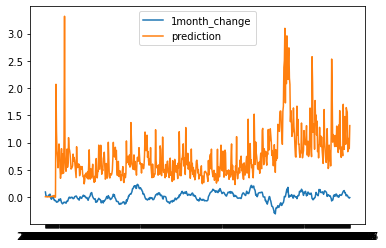

In [30]:
# 테스트 데이터와 예측값의 시각화
plt.figure()
plt.plot(target_['1month_change'], label='1month_change')
plt.plot(target_['pred'], label = 'prediction')
plt.legend()
plt.show()


- 예측값과 답 사이에 기본적으로 수준차이가 매우 크게 나타난다.
- 근데 뭔가 예측값이 노이즈가 많이 낀 시그널처럼 보이기도 한다

- pred 값과 1 month change 값을 0~1사이로 Normalize 해보자

In [31]:
scaler = MinMaxScaler()

In [39]:
pred = pred.reshape(-1,1)
pred_normal = scaler.fit_transform(pred)

In [46]:
month_change = target_['1month_change'].values.reshape(-1,1)
month_change_normal = scaler.fit_transform(month_change)

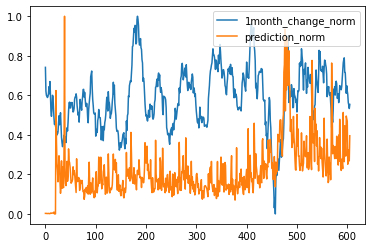

In [48]:
# Normalize 후 테스트 데이터와 예측값의 시각화
plt.figure()
plt.plot(month_change_normal, label='1month_change_norm')
plt.plot(pred_normal, label = 'prediction_norm')
plt.legend(loc = 'best')
plt.show()



In [45]:
target_['1month_change'].values.shape

(606,)

- 노이즈의 영향이 더 크게 보인다.

- 선형회귀는 예상대로 적합한 툴이 아니다

- 다른 알고리즘으로 넘어가자
- ## 위 내용 정리해두기!